# DSCI 100 - Final Project Report

## Introduction

This project was made to analyse the research of a UBC lab looking to observe how people play video games. Players are volunteers who sign up to play in a Minecraft server where their actions and data are recorded. 

Our project focuses on predicting whether the age of users predict the amount of playing time spent within the server. 

There are two datasets available to work from. One contains information collected when a player first signs up to join the server, and the second dataset records the playing time of each session. The first data set includes the age, gender, name, hours played, the hashed email, whether they are subscribed to the research group’s newsletter, and the experience playing Minecraft of the users. The second includes the hashed emails, start and stop times, using dates and time of day, and original start and stop times of sessions on the server. 

## Methods & Results

### 1. Data loading and initial cleaning

We focused on the `players.csv` file, which contains one row per player with demographic information and their total recorded play time on the UBC Minecraft research server. The analysis was done in R using the following libraries.

In [1]:
library(tidyverse)
library(readr)
library(tidymodels)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Read players.csv
players_url  <- "https://raw.githubusercontent.com/Elijah-Lal/DSCI-100-Group-17-Project-Final-Report/refs/heads/main/players.csv"
dir.create("data", showWarnings = FALSE)
download.file(players_url,  destfile = "data/players.csv", mode = "wb")
players  <- read_csv("data/players.csv")


# Keep only the variables needed for this analysis and drop missing values
player_data <- players |>
  select(age = Age, played_hours) |>
  drop_na()

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2. Exploratory data analysis

To understand the structure of the data and guide the modelling process, we first calculated summary statistics for age and total play time. We then visualized the distribution of play time and examined the relationship between age and played hours.

**Figure 1.** 
Summary statistics for age and total hours played. The mean player age is around 21 years, while total play time is heavily right-skewed, with most players having very few hours and a small number accumulating extremely high totals.

In [3]:
summary_stats <- player_data |>
  summarise(
    n_players        = n(),
    mean_age         = mean(age),
    sd_age           = sd(age),
    mean_played      = mean(played_hours),
    median_played    = median(played_hours),
    sd_played        = sd(played_hours)
  )

summary_stats

n_players,mean_age,sd_age,mean_played,median_played,sd_played
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.13918,7.389687,5.904639,0.1,28.49793


**Figure 2.** Histogram of total hours played. Most players log fewer than five hours, while a small number log more than fifty, indicating a highly skewed activity distribution.

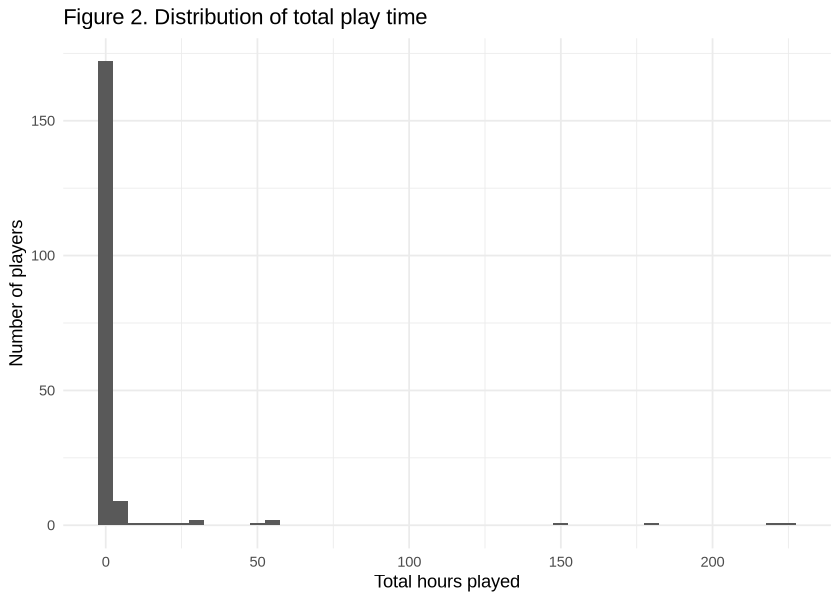

In [4]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(player_data, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(
    title = "Figure 2. Distribution of total play time",
    x = "Total hours played",
    y = "Number of players"
  ) +
  theme_minimal()

**Figure 3.** Scatterplot of age versus total hours played, with a fitted linear regression line. There is no strong visual relationship, suggesting that age alone may not be a meaningful predictor of play time.

`geom_smooth()` using formula = 'y ~ x'


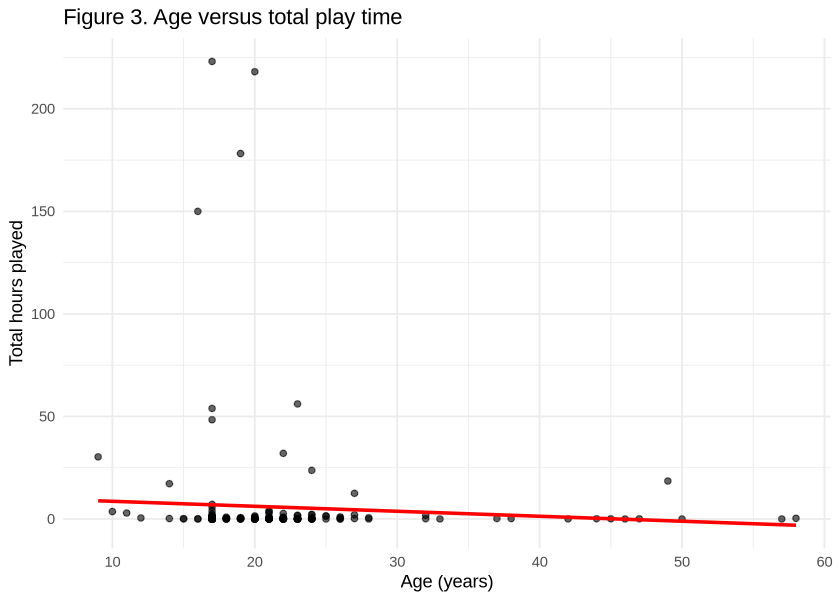

In [5]:
ggplot(player_data, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", se = FALSE, colour = "red") +
  labs(
    title = "Figure 3. Age versus total play time",
    x = "Age (years)",
    y = "Total hours played"
  ) +
  theme_minimal()

### 3. Modelling approach

Because `played_hours` is a continuous variable, we modelled this as a regression problem: *Can a player's age predict how many hours they will spend on the server?*

We compared two models:

1. A **linear regression model** assuming a straight-line relationship between age and expected play time.
2. A **k-nearest neighbours (k-NN) regression model**, which predicts a player's play time by averaging the play times of the k most similar players (in age).

Each model was fit on 75% of the data and evaluated on the remaining 25% using RMSE, MAE, and R².

In [6]:
player_split <- initial_split(player_data, prop = 0.75)
player_train <- training(player_split)
player_test  <- testing(player_split)

### 3.1 Linear regression model

We first fit a linear regression model using age as the sole predictor of total play time.

In [7]:
lin_player_spec <- linear_reg() |>
       set_engine("lm") |>
      set_mode("regression")

lin_player_recipe <- recipe(played_hours ~ age, data = player_training)

lin_player_fit <- workflow() |>
       add_recipe(lin_player_recipe) |>
       add_model(lin_player_spec) |>
       fit(player_training)

ERROR: Error in eval(expr, envir, enclos): object 'player_training' not found


**Figure 4.** Performance metrics for the linear regression model. The RMSE and MAE are large relative to the average play time, and R² is extremely close to zero.

In [ ]:
lin_metrics <- lin_player_predictions |>
  metrics(truth = played_hours, estimate = .pred)

lin_metrics

**Figure 5.** Observed play times (points) and linear regression predictions (red line).

In [ ]:
lin_aug <- augment(lin_player_fit, new_data = player_data)

ggplot(lin_aug, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  geom_line(aes(y = .pred), colour = "red", linewidth = 1) +
  labs(
    title = "Figure 5. Linear regression fit: age vs total play time",
    x = "Age (years)",
    y = "Total hours played"
  ) +
  theme_minimal()

### 3.2 k-nearest neighbours regression

To test whether a more flexible, non-parametric method could capture the relationship between age and play time, we fit a k-NN regression model. Because k-NN relies on distances, we normalize the predictor during preprocessing. In addition, we perform cross-validation and tuning to determine the optimal choice for the number of neighbours to consider.

In [ ]:
k_player_vfold <- vfold_cv(player_training, v = 5, strata = played_hours)

kvals <- tibble(neighbors =seq(from = 1, to = 15, by = 1) )
knn_player_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

knn_player_recipe <- recipe( played_hours ~ age, data = player_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

knn_player_accuracy <- workflow() |>
       add_recipe(knn_player_recipe) |>
       add_model(knn_player_spec_tune) |>
       tune_grid(resamples = k_player_vfold, grid = kvals) |>
       collect_metrics() |>
       filter(.metric == "rmse") |>
       filter(mean == min(mean))
knn_player_accuracy


#Next we create the final knn spec and fit to use to compare with lin reg
knn_player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
       set_engine("kknn") |>
       set_mode("regression") 
knn_player_fit <- workflow() |>
       add_recipe(knn_player_recipe) |>
       add_model(knn_player_spec) |>
       fit(player_training)

**Figure 6.** Performance metrics for the k-NN regression model. RMSE and R² are nearly identical to the linear regression results, confirming that even a flexible model cannot meaningfully predict play time from age alone.

In [ ]:
knn_metrics <- knn_player_predictions |>
  metrics(truth = played_hours, estimate = .pred)

knn_metrics